## Import the libs

In [137]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.models import load_model
import pickle

## Import and read the data

In [138]:
data_path = "./data/amazon_data.csv"
data = pd.read_csv(data_path)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
1,2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2,2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
3,2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
4,2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000
...,...,...,...,...,...,...,...
6032,2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
6033,2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
6034,2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700
6035,2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000


In [139]:
close_data = data['Adj Close'].values
close_data

array([  4.46875   ,   4.09687519,   3.48749995, ..., 153.33999634,
       153.38000488, 151.94000244])

## Processing data

In [140]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(close_data.reshape(-1, 1))
print(type(scaled_data))
print(scaled_data)
np.save('amazon_scaled.npy', scaled_data)

<class 'numpy.ndarray'>
[[-0.64884094]
 [-0.65605641]
 [-0.66788009]
 ...
 [ 2.2397016 ]
 [ 2.24047789]
 [ 2.21253758]]


### Plotting

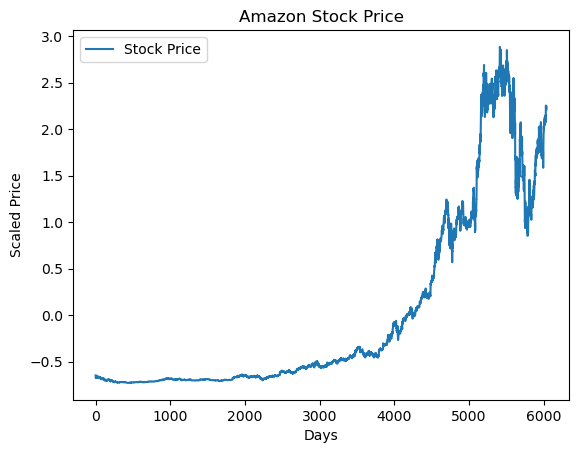

In [141]:
plt.figure(edgecolor='blue')
plt.title('Amazon Stock Price')
plt.xlabel('Days')
plt.ylabel('Scaled Price')
plt.plot(scaled_data, label='Stock Price')
plt.legend()
plt.savefig('./figs/stock_price.png')
plt.show()


## Train, test and CV data

In [142]:
def window_size(data, size):
    X = []
    y = []
    i = 0

    while (i + size) <= len(data) - 1:
        X.append(data[i:i+size])
        y.append(data[i+size])
        i += 1
    
    assert len(X) == len(y)
    
    return X, y

X, y = window_size(scaled_data, 7)

In [143]:
data_size = len(X)
split_percnt = 0.8
split_point=round(len(data)*split_percnt)

X_train = np.array(X[:split_point])
y_train = np.array(y[:split_point])

X_test = np.array(X[split_point:])
y_test = np.array(y[split_point:])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

np.save('./data/X_train.npy', X_train)
np.save('./data/y_train.npy', y_train)
np.save('./data/X_test.npy', X_test)
np.save('./data/y_test.npy', y_test)

(4830, 7, 1) (4830, 1)
(1200, 7, 1) (1200, 1)


## model

In [222]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

## training

In [223]:
history = model.fit(x=X_train,y=y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)

with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Train on 4830 samples, validate on 1200 samples
Epoch 1/300
4830/4830 [==============================] - 3s 579us/sample - loss: 0.0119 - val_loss: 0.2685
Epoch 2/300


c:\Users\mpps\anaconda3\envs\lstmenv\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4830/4830 [==============================] - 2s 315us/sample - loss: 0.0042 - val_loss: 0.1719
Epoch 3/300
4830/4830 [==============================] - 1s 256us/sample - loss: 7.1283e-04 - val_loss: 0.2689
Epoch 4/300
4830/4830 [==============================] - 1s 295us/sample - loss: 0.0011 - val_loss: 0.4263
Epoch 5/300
4830/4830 [==============================] - 1s 234us/sample - loss: 0.0026 - val_loss: 0.5188
Epoch 6/300
4830/4830 [==============================] - 1s 247us/sample - loss: 0.0040 - val_loss: 0.7797
Epoch 7/300
4830/4830 [==============================] - 1s 223us/sample - loss: 0.0035 - val_loss: 0.5829
Epoch 8/300
4830/4830 [==============================] - 1s 270us/sample - loss: 0.0132 - val_loss: 0.5327
Epoch 9/300
4830/4830 [==============================] - 1s 237us/sample - loss: 0.0028 - val_loss: 0.3152
Epoch 10/300
4830/4830 [==============================] - 1s 289us/sample - loss: 0.0077 - val_loss: 0.1818
Epoch 11/300
4830/4830 [====================

In [224]:
model.save("./model/lstm.h5")

In [17]:
model = load_model("./model/lstm.h5")

# load trainning history
with open('./model/history.pkl', 'rb') as file:
    history_loaded = pickle.load(file)

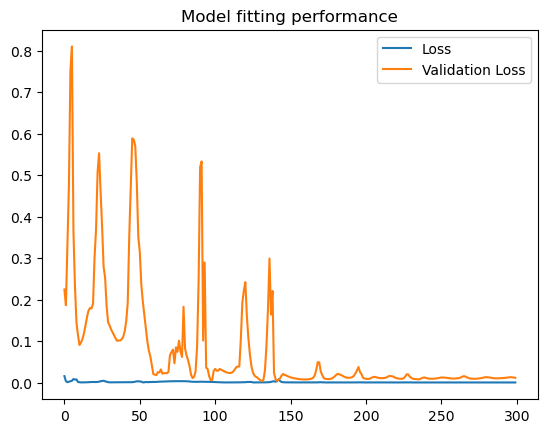

In [144]:
axes=plt.axes()
axes.plot(pd.DataFrame(history_loaded)['loss'], label='Loss')
axes.plot(pd.DataFrame(history_loaded)['val_loss'], label='Validation Loss')
axes.legend(loc=0)
axes.set_title('Model fitting performance')
plt.savefig('./figs/model-fitting.png')

In [145]:
y_predicted=scaler.inverse_transform(model.predict(X_test))
print(y_predicted.shape)
y_true=scaler.inverse_transform(y_test.reshape(y_test.shape[0],1))

(1200, 1)


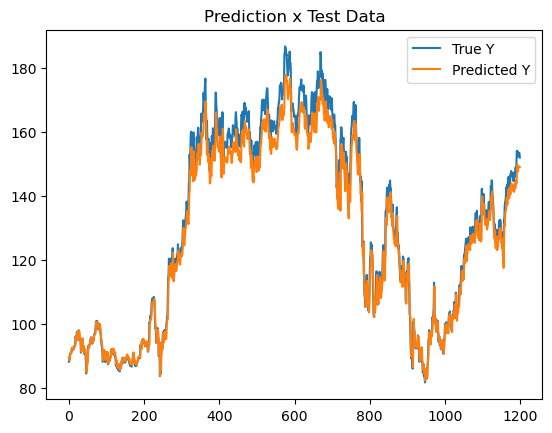

In [146]:
axes = plt.axes()
axes.plot(y_true, label='True Y')
axes.plot(y_predicted, label='Predicted Y')
axes.legend(loc=0)
axes.set_title('Prediction x Test Data')
plt.savefig('./figs/prediction_test_data.png')

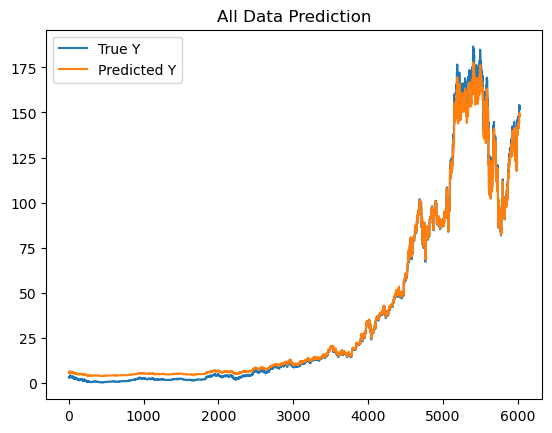

In [147]:
X_data = np.concatenate((X_train, X_test), axis=0)
y_data = np.concatenate((y_train, y_test), axis=0)

y_predicted=scaler.inverse_transform(model.predict(X_data))
y_true=scaler.inverse_transform(y_data.reshape(y_data.shape[0],1))

axes = plt.axes()
axes.plot(y_true, label='True Y')
axes.plot(y_predicted, label='Predicted Y')
axes.legend(loc=0)
axes.set_title('All Data Prediction')
plt.savefig('./figs/all_data_prediction.png')

In [154]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# MAE (Erro Médio Absoluto)
mae = mean_absolute_error(y_true, y_predicted)

# MSE (Erro Quadrático Médio)
mse = mean_squared_error(y_true, y_predicted)

# RMSE (Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 2.229696789542043
Mean Squared Error: 8.244846579947144
Root Mean Squared Error: 2.871384087848079


In [179]:
import numpy as np
import matplotlib.pyplot as plt

def predict_future(model, scaled_data, n_days, scaler):
    future_predictions = []
    
    X, _ = window_size(scaled_data, 7)
    X_data = np.array(X)
    current_input = X_data.reshape((X_data.shape[0], X_data.shape[1], 1))[-1]

    for _ in range(n_days):
        seq = current_input[-7:].reshape((1, 7, 1))
        y_pred = model.predict(seq)
        y_pred_rescaled = scaler.inverse_transform(y_pred).reshape(-1)
        future_predictions.append(y_pred_rescaled[0])
        
        current_input = np.append(current_input[1:], y_pred)
    
    return np.array(future_predictions)

            Date   Adj Close
0     2000-01-03    4.468750
1     2000-01-04    4.096875
2     2000-01-05    3.487500
3     2000-01-06    3.278125
4     2000-01-07    3.478125
...          ...         ...
6085  2024-03-12  175.389999
6086  2024-03-13  176.559998
6087  2024-03-14  178.750000
6088  2024-03-15  174.419998
6089  2024-03-18  174.479996

[6090 rows x 2 columns]
6090


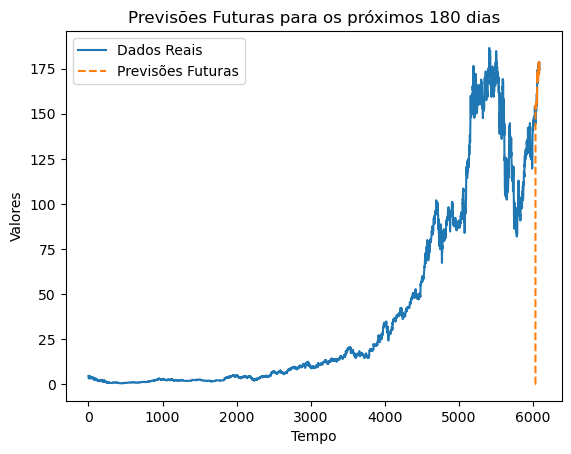

In [180]:
latest_data = pd.read_csv('./data/amazon_data_latest.csv')
latest_data = latest_data[["Date", "Adj Close"]]
latest_data = latest_data[:len(y_data)+60]
latest_data_amazon = latest_data.copy()
print(latest_data)
print(len(y_data)+60)

plt.plot(latest_data["Adj Close"], label='Dados Reais')
plt.title('Previsões Futuras para os próximos 180 dias')
plt.xlabel('Tempo')
plt.ylabel('Valores')
plt.legend()
plt.show()


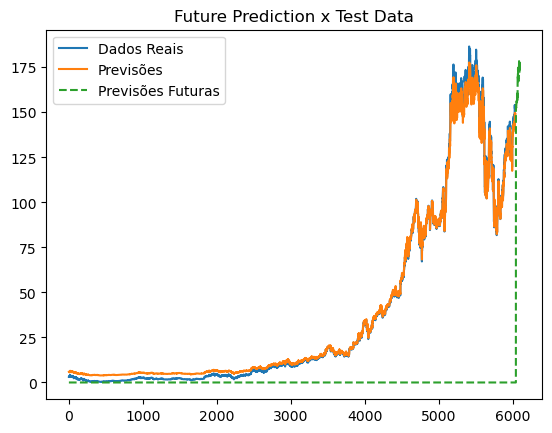

In [181]:
split = len(latest_data) - len(y_data)
latest_data = latest_data[-split:]
latest_data_close = latest_data["Adj Close"].values

scaler = StandardScaler()
scaled_data_future = scaler.fit_transform(latest_data_close.reshape(-1, 1))

X_future, y_future = window_size(scaled_data_future, 7)
X_future = np.array(X_future)
y_future = np.array(y_future)

y_predicted_future=scaler.inverse_transform(model.predict(X_future))
y_true_future=scaler.inverse_transform(y_future.reshape(y_future.shape[0],1))

future = np.zeros(len(latest_data_amazon))
future[-len(y_predicted_future):] = y_predicted_future.reshape(-1)

axes = plt.axes()
axes.plot(range(len(y_true)), y_true, label='Dados Reais')
axes.plot(range(len(y_true)), y_predicted, label='Previsões')
axes.plot(range(len(y_true)+60), future, label='Previsões Futuras', linestyle='--')
axes.legend(loc=0)
axes.set_title('Future Prediction x Test Data')
plt.savefig('./figs/future_prediction_test_data.png')
plt.show()

## Hyperparameters

In [ ]:
batch_size = 7
window_size = 7
hidden_layer = 256
clip_margin = 4
learning_rate = 0.001
epochs = 300

## Model with hypermarameters

In [ ]:
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(hidden_layer, input_shape=(window_size, 1)))
model.add(Dense(1))

optimizer = Adam(learning_rate=learning_rate, clipnorm=clip_margin)

model.compile(optimizer=optimizer, loss='mse')

history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=False)

model.save("./model/lstm2.h5")

with open('./model/history2.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Train on 4830 samples, validate on 1200 samples
Epoch 1/300
4788/4830 [============================>.] - ETA: 0s - loss: 0.0022

c:\Users\mpps\anaconda3\envs\lstmenv\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4830/4830 [==============================] - 3s 700us/sample - loss: 0.0022 - val_loss: 0.0904
Epoch 2/300
4830/4830 [==============================] - 3s 591us/sample - loss: 0.0010 - val_loss: 0.0177
Epoch 3/300
4830/4830 [==============================] - 3s 574us/sample - loss: 5.2805e-04 - val_loss: 0.0233
Epoch 4/300
4830/4830 [==============================] - 3s 560us/sample - loss: 4.5361e-04 - val_loss: 0.0254
Epoch 5/300
4830/4830 [==============================] - 3s 591us/sample - loss: 3.8976e-04 - val_loss: 0.0331
Epoch 6/300
4830/4830 [==============================] - 3s 614us/sample - loss: 3.5563e-04 - val_loss: 0.0366
Epoch 7/300
4830/4830 [==============================] - 3s 596us/sample - loss: 3.1604e-04 - val_loss: 0.0371
Epoch 8/300
4830/4830 [==============================] - 3s 600us/sample - loss: 2.9541e-04 - val_loss: 0.0418
Epoch 9/300
4830/4830 [==============================] - 3s 587us/sample - loss: 2.5495e-04 - val_loss: 0.0425
Epoch 10/300
4830/483

In [ ]:
model = load_model("./model/lstm2.h5")

# Carregar o histórico de treinamento
with open('./model/history2.pkl', 'rb') as file:
    history_loaded = pickle.load(file)

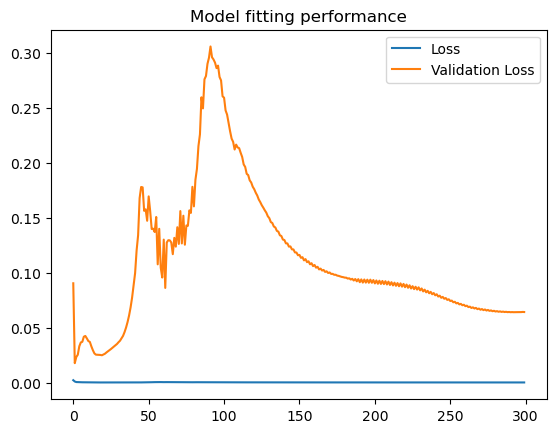

In [ ]:
axes=plt.axes()
axes.plot(pd.DataFrame(history_loaded)['loss'], label='Loss')
axes.plot(pd.DataFrame(history_loaded)['val_loss'], label='Validation Loss')
axes.legend(loc=0)
axes.set_title('Model fitting performance')
plt.savefig('./figs/model_fitting_2.png')

c:\Users\mpps\anaconda3\envs\lstmenv\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


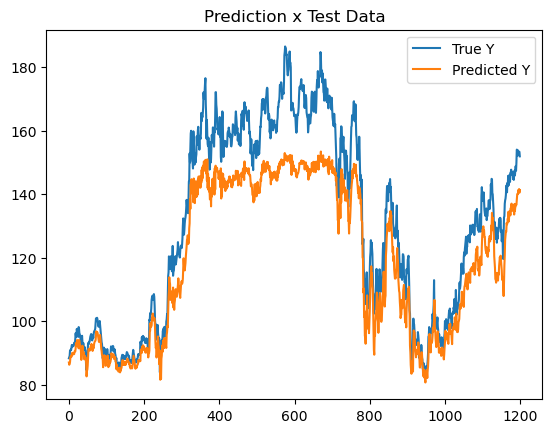

In [ ]:
y_predicted=scaler.inverse_transform(model.predict(X_test))
y_true=scaler.inverse_transform(y_test.reshape(y_test.shape[0],1))
axes = plt.axes()
axes.plot(y_true, label='True Y')
axes.plot(y_predicted, label='Predicted Y')
axes.legend(loc=0)
axes.set_title('Prediction x Test Data')
plt.savefig('./figs/prediction_test_data_2.png')

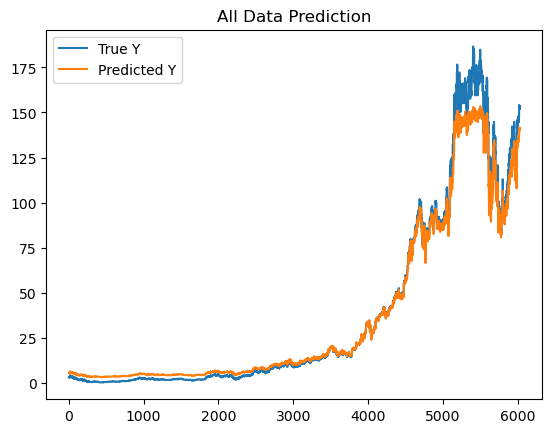

In [ ]:
X_data = np.concatenate((X_train, X_test), axis=0)
y_data = np.concatenate((y_train, y_test), axis=0)

y_predicted=scaler.inverse_transform(model.predict(X_data))
y_true=scaler.inverse_transform(y_data.reshape(y_data.shape[0],1))

axes = plt.axes()
axes.plot(y_true, label='True Y')
axes.plot(y_predicted, label='Predicted Y')
axes.legend(loc=0)
axes.set_title('All Data Prediction')
plt.savefig('./figs/all_data_prediction.png')

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Supondo que `y_true` contém os valores reais para os próximos 365 dias
# E `predictions` contém as previsões para os mesmos dias

# Calcular MAE (Erro Médio Absoluto)
mae = mean_absolute_error(y_true, y_predicted)

# Calcular MSE (Erro Quadrático Médio)
mse = mean_squared_error(y_true, y_predicted)

# Calcular RMSE (Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 3.58541004724467
MSE: 37.25375955083651
RMSE: 6.103585794501173


## Model 3: Pytorch

In [194]:
batch_size = 7
window_size = 7
hidden_layer = 256
clip_margin = 4
learning_rate = 0.001
epochs = 300
input_size = 1
output_size = 1

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [205]:
# load the data
df = pd.read_csv('./data/amazon_data.csv')

df['Date'] = pd.to_datetime(df['Date'])
data = df[['Date', 'Adj Close']].copy()

# normalize
scaler = StandardScaler()
data['Adj Close'] = scaler.fit_transform(data['Adj Close'].values.reshape(-1, 1)).reshape(-1)

# 7 day sequence
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data['Adj Close'].values[i:i+window_size])
        labels.append(data['Adj Close'].values[i+window_size])
    return np.array(sequences), np.array(labels)

X, y = create_sequences(data, window_size)

# split data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# reshape data to [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [199]:
# define LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Callbacks to save the best model and early stopping
checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')


In [200]:
# fit model
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    callbacks=[checkpoint, early_stopping], 
    shuffle=False
)


Train on 4824 samples, validate on 1206 samples
Epoch 1/300
4824/4824 [==============================] - 7s 1ms/sample - loss: 0.0023 - val_loss: 0.1038
Epoch 2/300
4824/4824 [==============================] - 6s 1ms/sample - loss: 0.0011 - val_loss: 0.0153
Epoch 3/300
4824/4824 [==============================] - 6s 1ms/sample - loss: 5.5755e-04 - val_loss: 0.0192
Epoch 4/300
4824/4824 [==============================] - 6s 1ms/sample - loss: 4.6026e-04 - val_loss: 0.0212
Epoch 5/300
4824/4824 [==============================] - 6s 1ms/sample - loss: 4.0315e-04 - val_loss: 0.0264
Epoch 6/300
4824/4824 [==============================] - 7s 1ms/sample - loss: 3.5372e-04 - val_loss: 0.0317
Epoch 7/300
4824/4824 [==============================] - 7s 2ms/sample - loss: 3.3060e-04 - val_loss: 0.0322
Epoch 8/300
4824/4824 [==============================] - 10s 2ms/sample - loss: 2.9680e-04 - val_loss: 0.0307
Epoch 9/300
4824/4824 [==============================] - 6s 1ms/sample - loss: 2.6919e-

In [ ]:
# load the best model
model.load_weights('best_lstm_model.h5')

LSTMModel(
  (lstm): LSTM(1, 256)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [201]:
# make predictions
y_pred = model.predict(X_test)

# revert standardization
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

c:\Users\mpps\anaconda3\envs\lstmenv\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


MAE: 14.656470461666682
MSE: 312.6602101383298
RMSE: 17.68220037603719


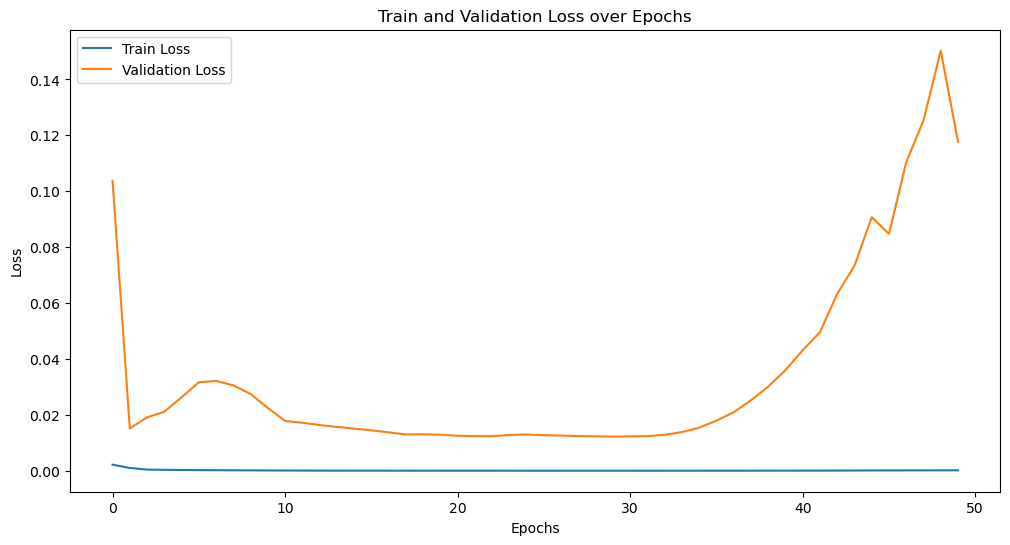

<Figure size 640x480 with 0 Axes>

In [202]:
# plot loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss over Epochs')
plt.show()
plt.savefig('./figs/train_validation_loss_5.png')

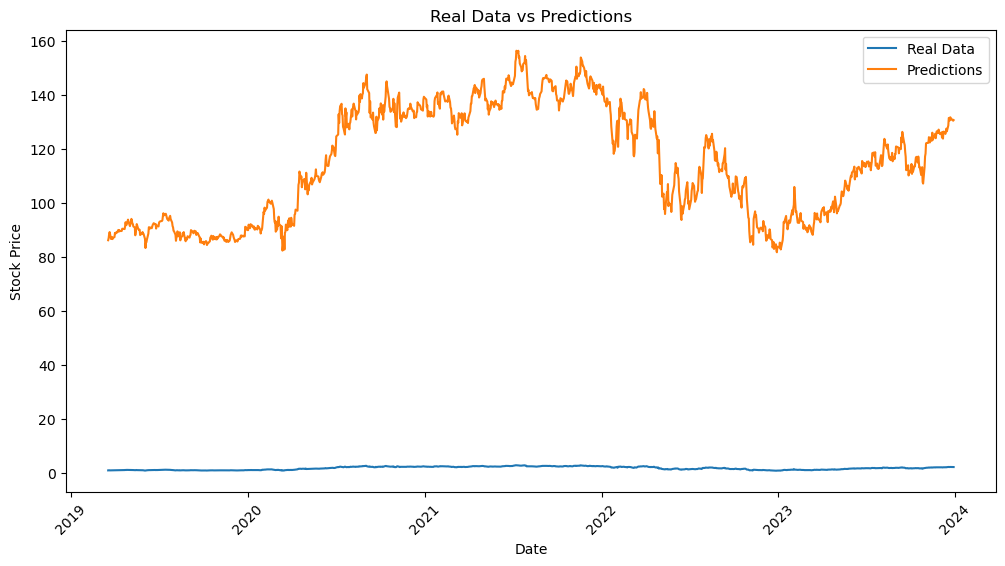

In [207]:
# Obter as datas correspondentes para os dados de teste
test_dates = data['Date'].values[-len(y_test):]

# Plotar as previsões versus os valores reais ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Real Data')
plt.plot(test_dates, y_pred, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Real Data vs Predictions')
plt.xticks(rotation=45)
plt.show()

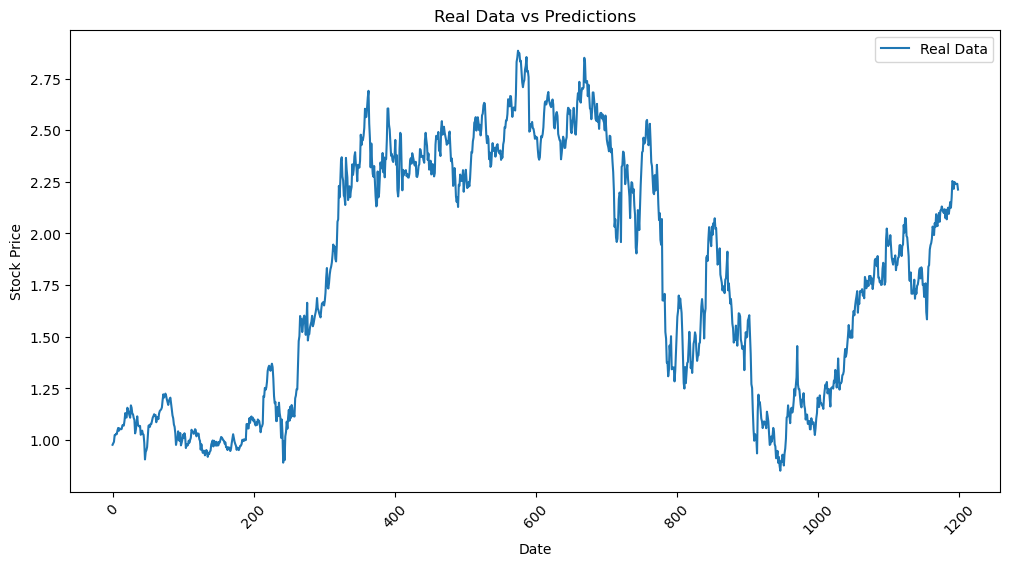

In [188]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Real Data')
# plt.plot(test_dates, test_predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Real Data vs Predictions')
plt.xticks(rotation=45)
plt.show()